In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

import torch 
import torchvision.models as models

In [ ]:
# Load model
model = models.googlenet(pretrained=True).cuda()

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


  0%|          | 0.00/49.7M [00:00<?, ?B/s]

In [ ]:
# list model modules
modules = [name for name, module in model.named_children()]
print(modules)

['conv1', 'maxpool1', 'conv2', 'conv3', 'maxpool2', 'inception3a', 'inception3b', 'maxpool3', 'inception4a', 'inception4b', 'inception4c', 'inception4d', 'inception4e', 'maxpool4', 'inception5a', 'inception5b', 'avgpool', 'dropout', 'fc']


In [ ]:
# freeze model parameters
for param in model.parameters():
  param.requires_grad_(False)

In [ ]:
# register hook for activations
activations = {}

def get_activation(name):
  def hook(model,input,output):
    activations[name] = output
  return hook

model.inception4a.register_forward_hook(get_activation("inception4a"))

In [ ]:
model.inception4a

Inception(
  (branch1): BasicConv2d(
    (conv): Conv2d(480, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (branch2): Sequential(
    (0): BasicConv2d(
      (conv): Conv2d(480, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(96, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicConv2d(
      (conv): Conv2d(96, 208, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(208, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (branch3): Sequential(
    (0): BasicConv2d(
      (conv): Conv2d(480, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicConv2d(
      (conv): Conv2d(16, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): Batc

In [ ]:
# generate random image
#optimization_image = np.float32(np.random.uniform(size=(32,32,3)))

!wget -O image.jpg https://24.p3k.hu/app/uploads/2016/04/teremtes-1024x575.jpg
optimization_image = cv2.imread("image.jpg")
optimization_image = cv2.resize(optimization_image,((299,299)))
optimization_image = optimization_image.astype(np.float32)
optimization_image/=255

# convert it to torch tensor
optimization_image = optimization_image.transpose(2,0,1)
optimization_tensor = torch.from_numpy(optimization_image).cuda().requires_grad_(True)

# set optimizer
optimizer = torch.optim.Adam([optimization_tensor], lr=0.01)


--2022-03-16 14:39:19--  https://24.p3k.hu/app/uploads/2016/04/teremtes-1024x575.jpg
Resolving 24.p3k.hu (24.p3k.hu)... 77.111.90.201, 77.111.90.200
Connecting to 24.p3k.hu (24.p3k.hu)|77.111.90.201|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://s.24.hu/app/uploads/2016/04/teremtes-1024x575.jpg [following]
--2022-03-16 14:39:20--  https://s.24.hu/app/uploads/2016/04/teremtes-1024x575.jpg
Resolving s.24.hu (s.24.hu)... 77.111.91.114
Connecting to s.24.hu (s.24.hu)|77.111.91.114|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 237209 (232K) [image/jpeg]
Saving to: ‘image.jpg’

image.jpg           100%[===================>] 231.65K   651KB/s    in 0.4s    

2022-03-16 14:39:21 (651 KB/s) - ‘image.jpg’ saved [237209/237209]



Iteration 0 
Filter activation: 7.707364559173584


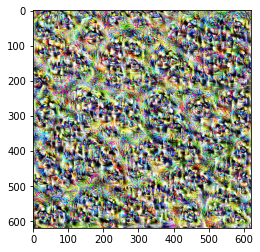

KeyboardInterrupt: ignored

In [ ]:
# set model to evaluation mode
model.eval()
# run model

iterations = 3000
upscale = 1.2

for iter in range(iterations):

  optimizer.zero_grad()

  model(optimization_tensor.unsqueeze(0))

  # record activation

  module_activation = activations["inception4a"]
  filter_activation = torch.mean(module_activation[0,225])


  # calculate loss
  loss = -filter_activation

  # optimize image
  loss.backward()
  optimizer.step()

  if iter%500==0:
    # visualize image
    print("Iteration {} \nFilter activation: {}".format(iter,filter_activation))
    image = optimization_tensor.cpu().clone().detach().numpy().transpose(1,2,0).clip(0,1)
    plt.imshow(image)
    plt.show()

  if iter%500==0:
    resized_image = cv2.resize(image, dsize=(0,0), fx=upscale, fy=upscale, interpolation=cv2.INTER_CUBIC)
    resized_image = resized_image.transpose(2,0,1)
    optimization_tensor = torch.from_numpy(resized_image).cuda().requires_grad_(True)
    optimizer = torch.optim.Adam([optimization_tensor], lr=0.01)